In [1]:
import zfit

/Users/mariehartmann/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/zfit/__init__.py:48: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."
/Users/mariehartmann/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/zfit/util/execution.py:73: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import uproot

In [5]:
import matplotlib 

In [6]:
import matplotlib.pyplot as plt

In [7]:
import mplhep

In [8]:
from numpy import random

In [9]:
#from matplotlib import rc
#rc('font',**{'family':'serif','serif':['Roman']})
#rc('text', usetex=True)

# Création d'un DataFrame contenant la masse du méson B

In [10]:
filename = 'root://eospublic.cern.ch//eos/opendata/lhcb/AntimatterMatters2017/data/B2HHH_MagnetDown.root'

In [11]:
tree = uproot.open(filename)["DecayTree"]

In [12]:
df = tree.arrays(library="pandas")

In [13]:
df.eval('H1_P = sqrt(H1_PX**2 + H1_PY**2 + H1_PZ**2)', inplace=True)
df.eval('H2_P = sqrt(H2_PX**2 + H2_PY**2 + H2_PZ**2)', inplace=True)
df.eval('H3_P = sqrt(H3_PX**2 + H3_PY**2 + H3_PZ**2)', inplace=True)

In [14]:
df.eval('B_P = sqrt((H1_PX + H2_PX + H3_PX)**2 + (H1_PY + H2_PY + H3_PY)**2 + (H1_PZ + H2_PZ + H3_PZ)**2 )', inplace=True)

In [15]:
df.eval('B_M =(sqrt((sqrt(493.677**2 + H1_P**2) + sqrt(493.677**2 + H2_P**2) + sqrt(493.677**2 + H3_P**2))**2 - B_P**2 ))', inplace=True)

In [16]:
df.keys()

Index(['B_FlightDistance', 'B_VertexChi2', 'H1_PX', 'H1_PY', 'H1_PZ',
       'H1_ProbK', 'H1_ProbPi', 'H1_Charge', 'H1_IPChi2', 'H1_isMuon', 'H2_PX',
       'H2_PY', 'H2_PZ', 'H2_ProbK', 'H2_ProbPi', 'H2_Charge', 'H2_IPChi2',
       'H2_isMuon', 'H3_PX', 'H3_PY', 'H3_PZ', 'H3_ProbK', 'H3_ProbPi',
       'H3_Charge', 'H3_IPChi2', 'H3_isMuon', 'H1_P', 'H2_P', 'H3_P', 'B_P',
       'B_M'],
      dtype='object')

# Application de filtres pour s'assurer que la masse que nous avons reconstruite est bien celle du méson B->K+K-K+

##### Filtre sur Hi_ProbK (proba que la particule Hi soit un kaon)

In [17]:
#df = df.query("H1_ProbK > 0.8 and H2_ProbK > 0.8 and H3_ProbK > 0.8")
df = df.query("H1_ProbK > 0.5 and H2_ProbK > 0.5 and H3_ProbK > 0.5")

##### Filtre sur Hi_ProbPi (proba que la particule Hi soit un pion)

In [18]:
#df = df.query("H1_ProbPi < 0.2 and H2_ProbPi < 0.2 and H3_ProbPi < 0.2")

##### Histogramme de la masse pour voir si notre résultat est satisfaisant

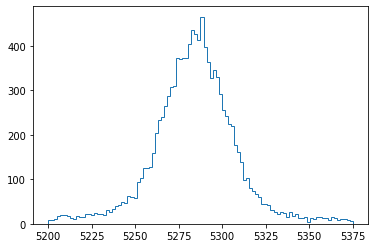

In [19]:
plt.hist(df['B_M'], range=(5200,5375), bins=100, histtype='step')
plt.show()

# Mise en place des outils nécessaires aux fits

##### Définition de l'espace observable

In [20]:
obs = zfit.Space('x', limits=(5200.,5375.))

##### Définition des data

In [21]:
#B_M = df['B_M'].to_numpy()
B_M = df['B_M'].to_numpy()
data = zfit.Data.from_numpy(obs=obs, array=B_M, weights=None)

In [97]:
data

In [22]:
print('écart type de B_M = {}'.format(B_M.std()))
print('nombre de données de B_M = {}'.format(len(B_M)))

écart type de B_M = 250.53383373604447
nombre de données de B_M = 17102


# FITS

In [23]:
minimizer = zfit.minimize.Minuit()

In [24]:
lower, upper = obs.limits
nb_bins = 50

<ipython-input-24-3a872e2760b6>:1: UserWarning: The function <function Space.limits at 0x14a905700> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5200.]]), array([[5375.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  lower, upper = obs.limits


In [25]:
counts, bin_edges = np.histogram(df['B_M'], bins=nb_bins, range=(lower[0][0], upper[0][0]))
x_plot = np.linspace(lower[0][0], upper[0][0], num=1000)

Dans la partie histogramme, il vaut mieux utiliser df['B_M'] plutôt que data.
On réservera data pour mettre en argument des fonctions zfit (cela ne marche pas avec une série comme df['B_M'])

## GAUSS

### Gauss classique

##### Définition des paramètres

In [26]:
sigma_gauss = zfit.Parameter('sigma_gauss', 197.)

In [27]:
mu_gauss = zfit.Parameter('mu_gauss', 5279.)

##### Définition du modèle

In [28]:
gauss = zfit.pdf.Gauss(obs=obs, mu=mu_gauss, sigma=sigma_gauss)

##### Définition de la 'loss function'

In [29]:
nll_gauss = zfit.loss.UnbinnedNLL(model=gauss, data=data)

##### Définition du minimizer

#voir en dessous de fit, je définis le même pour tout le monde

##### Minimisation du modèle et impression de résultats obtenus pour les paramètres

In [30]:
result_gauss = minimizer.minimize(nll_gauss)

E VariableMetricBuilder Initial matrix not pos.def.


In [31]:
result_gauss.params

{<zfit.Parameter 'mu_gauss' floating=True value=5284>: {'value': 5284.043955954763}, <zfit.Parameter 'sigma_gauss' floating=True value=24.15>: {'value': 24.151364345506614}}

In [32]:
print('The value of the B meson mass is : {}'.format(result_gauss.params[mu_gauss]))

The value of the B meson mass is : {'value': 5284.043955954763}


##### Vérification de la validité de notre fit

In [33]:
print(result_gauss.valid)
print(result_gauss.converged)

True
True


##### Tracé de l'histogramme

In [34]:
y_plot_gauss = zfit.run(gauss.pdf(x_plot, norm_range=obs))

<ipython-input-35-e3c3fde5b4bb>:2: UserWarning: The function <function Space.area at 0x14a908af0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5200.]]), array([[5375.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  plt.plot(x_plot, y_plot_gauss*df['B_M'].shape[0]/100*obs.area(), color='pink')


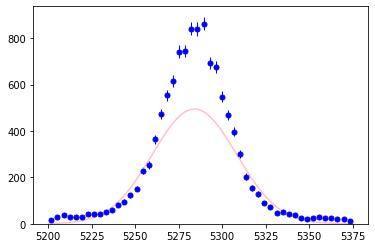

In [35]:
mplhep.histplot((counts,bin_edges), yerr = True, color = 'blue', histtype='errorbar')
plt.plot(x_plot, y_plot_gauss*df['B_M'].shape[0]/100*obs.area(), color='pink')
plt.show()

### Extended Gauss

##### Opérations zfit

Le yield est un paramètre qu'il faut définir lorsque l'on veut effectuer un extended fit. On lui donnera comme valeur maximale la len(df['B_M']).

In [36]:
yield_ex_gauss = zfit.Parameter("yield_ex_gauss", 100, 0, 2615)

Un extended fit s'effectue à partir d'un modèle déjà défini. Ici on réutilise le model gauss défini précedemment.

In [37]:
ex_gauss = gauss.create_extended(yield_ex_gauss)

La loss function est légeremment différente pour les extended fits.

In [38]:
nll_ex_gauss = zfit.loss.ExtendedUnbinnedNLL(model=ex_gauss, data=data)

On obtient les résultats de la même manière que pour une extended fit.

In [39]:
result_ex_gauss = minimizer.minimize(nll_ex_gauss)

In [40]:
result_ex_gauss.params

{<zfit.Parameter 'yield_ex_gauss' floating=True value=2615>: {'value': 2614.999999977295}, <zfit.Parameter 'mu_gauss' floating=True value=5284>: {'value': 5284.040338803824}, <zfit.Parameter 'sigma_gauss' floating=True value=24.15>: {'value': 24.150792667493988}}

In [41]:
print('The value of the B meson mass is : {}'.format(result_gauss.params[mu_gauss]))
print(result_gauss.valid)
print(result_gauss.converged)

The value of the B meson mass is : {'value': 5284.043955954763}
True
True


##### Tracé de l'histogramme

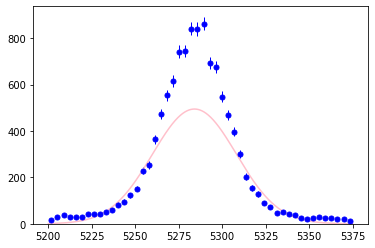

In [42]:
y_plot_ex_gauss = zfit.run(ex_gauss.pdf(x_plot, norm_range=obs))
mplhep.histplot((counts,bin_edges), yerr = True, color = 'blue', histtype='errorbar')
plt.plot(x_plot, y_plot_ex_gauss*df['B_M'].shape[0]/100*obs.area(), color='pink')
plt.show()

Remarque : l'histogramme est le même dans les deux cas. La seule chose qui a changé, c'est que l'on a accès au nombre d'évènements dans le pic.

## CRISTAL BALL

##### Paramètres

In [43]:
mu_cb = zfit.Parameter('mu_cb', 5279., 5270., 5300.)

In [44]:
sigma_cb = zfit.Parameter('sigma_cb', 20., 0., 400.)
#sigma max environ deux fois la sd

In [45]:
alpha_cb = zfit.Parameter('alpha_cb',0.5, 0., 5.)

In [46]:
n_cb = zfit.Parameter('n_cb', 1., 0., 100.)

In [47]:
yield_cb4 = zfit.Parameter("yield_cb4", 2000., 0.5, 10000.)

##### Model et Extended Model

In [48]:
cb = zfit.pdf.CrystalBall(obs=obs, mu=mu_cb, sigma=sigma_cb, alpha=alpha_cb, n=n_cb)

In [49]:
ex_cb = cb.create_extended(yield_cb4)

##### Loss functions

In [50]:
nll_cb = zfit.loss.UnbinnedNLL(model=cb, data=data)

In [51]:
nll_ex_cb = zfit.loss.ExtendedUnbinnedNLL(model=ex_cb, data=data)

##### Résultas

In [52]:
result_cb = minimizer.minimize(nll_cb)
result_cb.params

{<zfit.Parameter 'alpha_cb' floating=True value=2.147>: {'value': 2.1474009947694004}, <zfit.Parameter 'mu_cb' floating=True value=5285>: {'value': 5285.411678892103}, <zfit.Parameter 'n_cb' floating=True value=0.4568>: {'value': 0.45678367426492117}, <zfit.Parameter 'sigma_cb' floating=True value=22.27>: {'value': 22.269078962570642}}

In [53]:
print('The value of the B meson mass is : {}'.format(result_cb.params[mu_cb]))
print(result_cb.valid)
print(result_cb.converged)

The value of the B meson mass is : {'value': 5285.411678892103}
True
True


In [54]:
result_ex_cb = minimizer.minimize(nll_ex_cb)
result_ex_cb.params

{<zfit.Parameter 'yield_cb4' floating=True value=1e+04>: {'value': 9999.999975332044}, <zfit.Parameter 'alpha_cb' floating=True value=2.148>: {'value': 2.1481015631519824}, <zfit.Parameter 'mu_cb' floating=True value=5285>: {'value': 5285.412386188607}, <zfit.Parameter 'n_cb' floating=True value=0.4561>: {'value': 0.4561107870438674}, <zfit.Parameter 'sigma_cb' floating=True value=22.27>: {'value': 22.269868086729883}}

In [55]:
print('The value of the B meson mass is : {}'.format(result_ex_cb.params[mu_cb]))
print(result_ex_cb.valid)
print(result_ex_cb.converged)

The value of the B meson mass is : {'value': 5285.412386188607}
False
True


##### Histogrammes

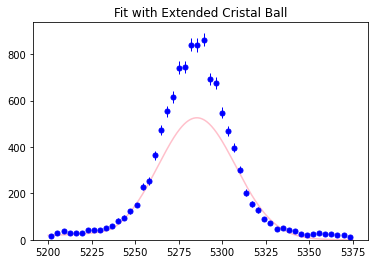

In [56]:
y_plot_ex_cb = zfit.run(ex_cb.pdf(x_plot, norm_range=obs))
mplhep.histplot((counts,bin_edges), yerr = True, color = 'blue', histtype='errorbar')
plt.plot(x_plot, y_plot_ex_cb*df['B_M'].shape[0]/100*obs.area(), color='pink')
plt.title('Fit with Extended Cristal Ball')
plt.show()

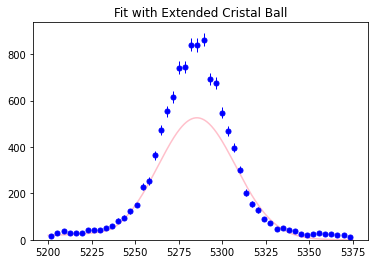

In [57]:
y_plot_cb = zfit.run(cb.pdf(x_plot, norm_range=obs))
mplhep.histplot((counts,bin_edges), yerr = True, color = 'blue', histtype='errorbar')
plt.plot(x_plot, y_plot_cb*df['B_M'].shape[0]/100*obs.area(), color='pink')
plt.title('Fit with Extended Cristal Ball')
plt.show()

# FIT_TRAINING

### _Paramètres_

In [58]:
rand_int = random.randint(0,1000000,size=1)
mu_ = zfit.Parameter(f"mu_{rand_int}", 5278., 5270., 5300.)

In [59]:
rand_int = random.randint(0,1000000,size=1)
mu_bis = zfit.Parameter(f"mu_bis_{rand_int}", 5278., 5270., 5300.)

In [60]:
rand_int = random.randint(0,1000000,size=1)
sigma_ = zfit.Parameter(f"sigma_{rand_int}", 21., 0., 400.)

In [61]:
rand_int = random.randint(0,1000000,size=1)
sigma_bis = zfit.Parameter(f"sigma__bis{rand_int}", 50., 0., 400.)

In [62]:
rand_int = random.randint(0,1000000,size=1)
alpha_ = zfit.Parameter(f"alpha_{rand_int}", 0.52, 0., 5.)

In [63]:
rand_int = random.randint(0,1000000,size=1)
n_ = zfit.Parameter(f"n_{rand_int}", 1., 0., 99.)

In [64]:
rand_int = random.randint(0,1000000,size=1)
l = zfit.Parameter(f"l_{rand_int}", -0.5, -1., -0.)

In [65]:
rand_int = random.randint(0,1000000,size=1)
yield_ = zfit.Parameter(f"yield_{rand_int}", 2000., 0.5, 10000.)

In [66]:
rand_int = random.randint(0,1000000,size=1)
n_sig = zfit.Parameter(f"n_sig_{rand_int}", 2000., 0.5, 10000.)

In [67]:
rand_int = random.randint(0,1000000,size=1)
n_bkg = zfit.Parameter(f"n_bkg_{rand_int}", 2000., 0.5, 10000.)

In [68]:
rand_int = random.randint(0,1000000,size=1)
frac_ = zfit.Parameter(f"frac_{rand_int}", 0.8, 0., 1.)

### _Modèles_

**Exponentielle + Crystal Ball**

On va sommer des pdf extended qui vont donner un SumPDF qui le sera également. Pour cette raison, je ne précise pas ex pour extended sauf pour les composantes initiales.

On précise n_bkg_ et n_sig car il n'y a pas autant d'évènements de bruits que de signal.

In [69]:
exp = zfit.pdf.Exponential(obs=obs, lambda_=l)
#il faut mettre un tiret du bas car sinon il pense que lambda définit une fonction
ex_exp = exp.create_extended(n_bkg)
ex_cb = cb.create_extended(n_sig)

In [70]:
exp_cb = zfit.pdf.SumPDF(pdfs=[ex_cb,ex_exp]) 
#already extended because sum of extended

**Two Crystall Ball pdfs**

In [71]:
cb_bis = zfit.pdf.CrystalBall(obs=obs, mu=mu_, sigma=sigma_, alpha=alpha_, n=n_)
ex_cb = cb.create_extended(n_sig)
ex_cb_bis = cb_bis.create_extended(n_bkg)

In [72]:
two_cb = zfit.pdf.SumPDF(pdfs=[ex_cb, ex_cb_bis])

**Two Gaussians**

In [73]:
gauss = zfit.pdf.Gauss(obs=obs, mu=mu_, sigma=sigma_)
gauss_bis = zfit.pdf.Gauss(obs=obs, mu=mu_bis, sigma=sigma_bis)

In [74]:
gaussians = zfit.pdf.SumPDF(pdfs=[gauss, gauss_bis], fracs=frac_)

In [75]:
two_gauss = gaussians.create_extended(yield_)

**Two Gaussians + exp**

In [76]:
exp = zfit.pdf.Exponential(obs=obs, lambda_=l)

In [77]:
ex_exp = exp.create_extended(n_bkg)
ex_two_gauss = gaussians.create_extended(n_sig)

In [78]:
model = zfit.pdf.SumPDF(pdfs=[ex_two_gauss, ex_exp])

### _Loss Function_

**Exponentielle + Crystal Ball**

In [79]:
nll_exp_cb = zfit.loss.ExtendedUnbinnedNLL(model=exp_cb, data=data)

**Two Crystall Ball pdfs**

In [80]:
nll_two_cb = zfit.loss.ExtendedUnbinnedNLL(model=two_cb, data=data)

**Two Gaussians**

In [81]:
nll_two_gauss = zfit.loss.ExtendedUnbinnedNLL(model=two_gauss, data=data)

**Two Gaussians + exp**

In [82]:
nll_model = zfit.loss.ExtendedUnbinnedNLL(model=model, data=data)

### _Résultats_

**Exponential + CB**

In [83]:
result_exp_cb = minimizer.minimize(nll_exp_cb)
result_exp_cb.params

{<zfit.Parameter 'n_sig_[987915]' floating=True value=1e+04>: {'value': 9999.999997160981}, <zfit.Parameter 'n_bkg_[169710]' floating=True value=1456>: {'value': 1456.3918127493196}, <zfit.Parameter 'alpha_cb' floating=True value=4.814>: {'value': 4.8137568841546265}, <zfit.Parameter 'mu_cb' floating=True value=5284>: {'value': 5284.307682746311}, <zfit.Parameter 'n_cb' floating=True value=1.113>: {'value': 1.1132244222708476}, <zfit.Parameter 'sigma_cb' floating=True value=17.73>: {'value': 17.729358992810983}, <zfit.Parameter 'l_[535999]' floating=True value=-0.002038>: {'value': -0.0020379937273851123}}

In [84]:
nsig = result_exp_cb.params[n_sig]['value']
nbkg = result_exp_cb.params[n_bkg]['value']
nevents = nsig + nbkg
#df['B_M'].shape[0]
print('Il y a {} évènements'.format(nevents))
print('Il y a {} évènements de signal'.format(nsig))
print('Il y a {} évènements de background'.format(nbkg))

Il y a 11456.391809910301 évènements
Il y a 9999.999997160981 évènements de signal
Il y a 1456.3918127493196 évènements de background


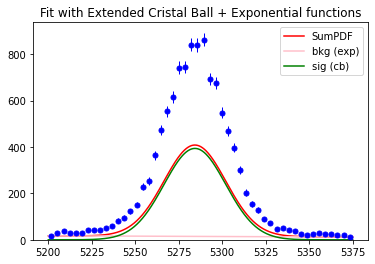

In [85]:
y_plot = zfit.run(exp_cb.pdf(x_plot, norm_range=obs))
y_plot_exp = zfit.run(ex_exp.pdf(x_plot, norm_range=obs))
y_plot_cb = zfit.run(ex_cb.pdf(x_plot, norm_range=obs))
mplhep.histplot((counts,bin_edges), yerr = True, color = 'blue', histtype='errorbar')
plt.plot(x_plot, y_plot*nevents/100*obs.area(), color='red', label='SumPDF')
plt.plot(x_plot, y_plot_exp*nbkg/100*obs.area(), color='pink', label='bkg (exp)')
plt.plot(x_plot, y_plot_cb*nsig/100*obs.area(), color='green', label='sig (cb)')
plt.title('Fit with Extended Cristal Ball + Exponential functions')
plt.legend()
plt.show()

Two CB

In [86]:
result_two_cb = minimizer.minimize(nll_two_cb)
result_two_cb.params

{<zfit.Parameter 'n_sig_[987915]' floating=True value=9578>: {'value': 9577.68625826184}, <zfit.Parameter 'n_bkg_[169710]' floating=True value=1925>: {'value': 1925.424406989315}, <zfit.Parameter 'alpha_cb' floating=True value=1.884>: {'value': 1.8839197016058193}, <zfit.Parameter 'mu_cb' floating=True value=5284>: {'value': 5284.313133818769}, <zfit.Parameter 'n_cb' floating=True value=39.34>: {'value': 39.337059395891245}, <zfit.Parameter 'sigma_cb' floating=True value=16.98>: {'value': 16.97745138208122}, <zfit.Parameter 'alpha_[425604]' floating=True value=0.7985>: {'value': 0.7985005518824104}, <zfit.Parameter 'mu_[482882]' floating=True value=5283>: {'value': 5282.763041120484}, <zfit.Parameter 'n_[476257]' floating=True value=96.98>: {'value': 96.98375649078503}, <zfit.Parameter 'sigma_[498051]' floating=True value=60.93>: {'value': 60.93053950405833}}

In [87]:
nsig = result_two_cb.params[n_sig]['value']
nbkg = result_two_cb.params[n_bkg]['value']
nevents = nsig + nbkg

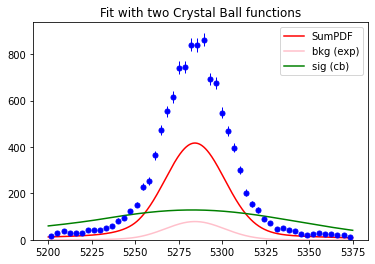

In [88]:
y_plot = zfit.run(two_cb.pdf(x_plot, norm_range=obs))
y_plot_exp = zfit.run(ex_cb.pdf(x_plot, norm_range=obs))
y_plot_cb = zfit.run(ex_cb_bis.pdf(x_plot, norm_range=obs))
mplhep.histplot((counts,bin_edges), yerr = True, color = 'blue', histtype='errorbar')
plt.plot(x_plot, y_plot*nevents/100*obs.area(), color='red', label='SumPDF')
plt.plot(x_plot, y_plot_exp*nbkg/100*obs.area(), color='pink', label='bkg (exp)')
plt.plot(x_plot, y_plot_cb*nsig/100*obs.area(), color='green', label='sig (cb)')
plt.title('Fit with two Crystal Ball functions')
plt.legend()
plt.show()

In [89]:
result_two_gauss = minimizer.minimize(nll_two_gauss)
result_two_gauss.params

{<zfit.Parameter 'yield_[565272]' floating=True value=1e+04>: {'value': 9999.999996457851}, <zfit.Parameter 'frac_[923110]' floating=True value=0.8144>: {'value': 0.8144373376426202}, <zfit.Parameter 'mu_[482882]' floating=True value=5284>: {'value': 5284.351654959024}, <zfit.Parameter 'sigma_[498051]' floating=True value=16.86>: {'value': 16.860182394539546}, <zfit.Parameter 'mu_bis_[823267]' floating=True value=5279>: {'value': 5278.75616367505}, <zfit.Parameter 'sigma__bis[807022]' floating=True value=58.97>: {'value': 58.9688764967319}}

In [90]:
nevents = result_two_gauss.params[yield_]['value']
fraction = result_two_gauss.params[frac_]['value']
ng = fraction*nevents
ng_bis = (1-fraction)*nevents

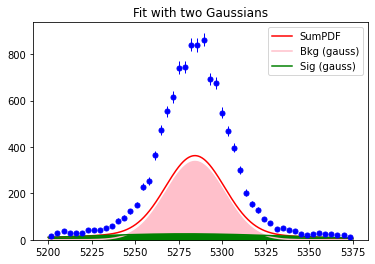

In [91]:
y_plot = zfit.run(two_gauss.pdf(x_plot, norm_range=obs))
y_plot_g = zfit.run(gauss.pdf(x_plot, norm_range=obs))
y_plot_g_bis = zfit.run(gauss_bis.pdf(x_plot, norm_range=obs))
mplhep.histplot((counts,bin_edges), yerr = True, color = 'blue', histtype='errorbar')
plt.plot(x_plot, y_plot*nevents/100*obs.area(), color='red', label='SumPDF')
plt.plot(x_plot, y_plot_g*ng/100*obs.area(), color='pink', label='Bkg (gauss)')
plt.plot(x_plot, y_plot_g_bis*ng_bis/100*obs.area(), color='green', label='Sig (gauss)')

plt.fill_between(x_plot, y_plot_g*ng/100*obs.area(), color='pink')
plt.fill_between(x_plot, y_plot_g_bis*ng_bis/100*obs.area(), color='green')

plt.title('Fit with two Gaussians')
plt.legend()
plt.show()

**Two Gaussians + exp**

In [92]:
result_model = minimizer.minimize(nll_model)
result_model.params

{<zfit.Parameter 'n_sig_[987915]' floating=True value=1e+04>: {'value': 9999.999681517715}, <zfit.Parameter 'n_bkg_[169710]' floating=True value=1311>: {'value': 1310.9243564674036}, <zfit.Parameter 'frac_[923110]' floating=True value=0.6866>: {'value': 0.6866268560166918}, <zfit.Parameter 'mu_[482882]' floating=True value=5285>: {'value': 5284.62546017418}, <zfit.Parameter 'sigma_[498051]' floating=True value=15.7>: {'value': 15.702741121105968}, <zfit.Parameter 'mu_bis_[823267]' floating=True value=5283>: {'value': 5283.238455204192}, <zfit.Parameter 'sigma__bis[807022]' floating=True value=23.41>: {'value': 23.406501830576353}, <zfit.Parameter 'l_[535999]' floating=True value=-0.001784>: {'value': -0.0017842724974586055}}

In [93]:
nsig = result_model.params[n_sig]['value']
nbkg = result_model.params[n_bkg]['value']
nevents = nsig + nbkg
print('Il y a {} évènements'.format(nevents))
print('Il y a {} évènements de signal'.format(nsig))
print('Il y a {} évènements de background'.format(nbkg))

Il y a 11310.924037985118 évènements
Il y a 9999.999681517715 évènements de signal
Il y a 1310.9243564674036 évènements de background


In [94]:
lower, upper = obs.limits
nb_bins = 50
counts, bin_edges = np.histogram(df['B_M'], bins=nb_bins, range=(lower[0][0], upper[0][0]))
x_plot = np.linspace(lower[0][0], upper[0][0], num=1000)
starting_bin = bin_edges[0]
final_bin = bin_edges[-1]

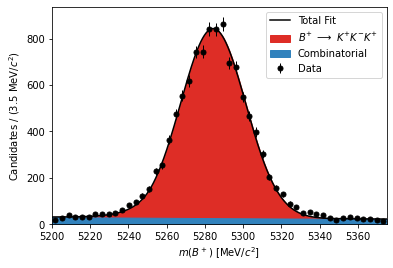

In [96]:
y_plot = zfit.run(exp_cb.pdf(x_plot, norm_range=obs))
y_plot_sig = zfit.run(ex_two_gauss.pdf(x_plot, norm_range=obs))
y_plot_bkg = zfit.run(ex_exp.pdf(x_plot, norm_range=obs))
mplhep.histplot((counts,bin_edges), yerr = True, color ='black', histtype='errorbar', label='Data')
plt.plot(x_plot, y_plot*nevents/nb_bins*obs.area(), color='black', label='Total Fit')
#plt.plot(x_plot, y_plot_bkg*nbkg/nb_bins*obs.area(), color='#3182bd', label='Combinatorial')
#plt.plot(x_plot, y_plot_sig*nsig/nb_bins*obs.area(), color='#de2d26', label='$B^+ \longrightarrow K^+K^-K^+$')

plt.fill_between(x_plot, y_plot*nevents/nb_bins*obs.area() , color= '#de2d26', label="$B^{+}$ $\longrightarrow$ $K^{+}K^{-}K^{+}$")
plt.fill_between(x_plot, y_plot_bkg*nbkg/nb_bins*obs.area(), color='#3182bd', label='Combinatorial')

plt.xlim(starting_bin,final_bin)
plt.xlabel("$m(B^+)$ [MeV/$c^2$]")
plt.ylabel("Candidates / ({} MeV/$c^2$)".format(round((final_bin-starting_bin)/nb_bins,2)))
plt.legend()
plt.show()